# Chat Intents

## Clustering without dimensionality reduction

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [30]:
X = data_sample['cleaned_text']
X.head()

0              im worried card might lost mail long usually take arrive
1                                         got charged fee shouldnt cash
2           charge making withdrawal took money account earlier charged
3    issue account dont see cheque deposit made yesterday please assist
4                                                 way people send money
Name: cleaned_text, dtype: object

### K-means with TF-IDF

In [7]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_transformed_vector = tfidf_vectorizer.fit_transform(X)
tfidf_transformed_vector.shape

(1000, 809)

In [8]:
k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(tfidf_transformed_vector)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [9]:
len(kmeans.labels_)

1000

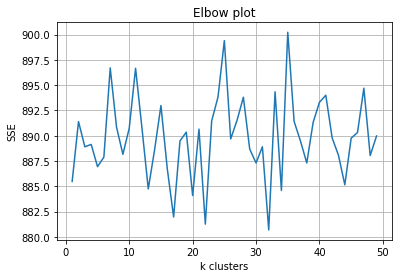

In [10]:
sse = []

for K in range(1, 50):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    kmeans.fit(tfidf_transformed_vector)
    sse.append(kmeans.inertia_)

x = range(1,50)
y = sse

fig, ax = plt. subplots()
ax.plot(x, y)

ax.set(xlabel = 'k clusters', ylabel = 'SSE',
       title = 'Elbow plot')
ax.grid()

plt.show()

### Sentence Embeddings

Start with Universal Sentence Encoder (USE) as an example sentence embedding model.

In [11]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [12]:
def embed_use(model, sentences):
    return model(sentences)

In [31]:
intents_embeddings = embed_use(model_use, X)
intents_embeddings.shape

TensorShape([1000, 512])

#### Sentence Embeddings + Kmeans

In [32]:
def plot_kmeans(embeddings, k_range):
    sse = []
    silhouette_avg_n_clusters = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(embeddings, kmeans.predict(embeddings))
        silhouette_avg_n_clusters.append(silhouette_avg)


    # plot sse
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(k_range, sse)
    axes[0].set(xlabel = 'k clusters', ylabel = 'SSE', title = 'Elbow plot')
    axes[0].grid()
    
    # plot avg silhouette score
    axes[1].plot(k_range, silhouette_avg_n_clusters)
    axes[1].set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    axes[1].grid()

    plt.show()

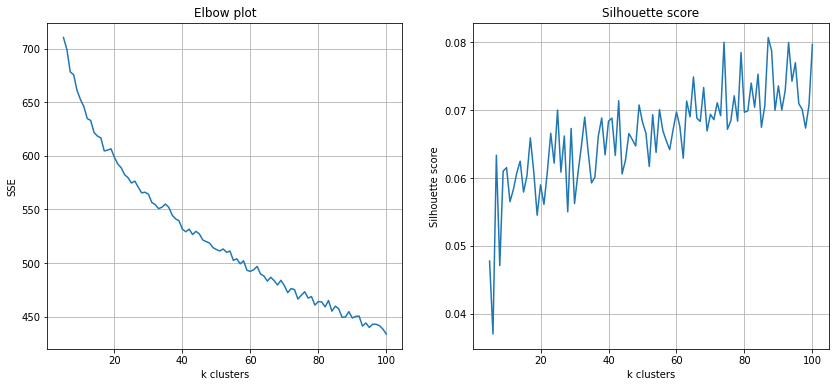

CPU times: user 39.1 s, sys: 1.56 s, total: 40.6 s
Wall time: 13.1 s


In [33]:
%%time

k_range = range(5, 101)

plot_kmeans(intents_embeddings, k_range)

#### Sentence Embeddings + DBSCAN with 

In [34]:
db = DBSCAN(eps=0.25, min_samples=5, metric='cosine').fit(intents_embeddings)
labels = db.labels_
len(np.unique(labels))

20

In [35]:
len(labels)

1000

In [36]:
silhouette_score(intents_embeddings, labels, metric='cosine')

-0.1875037

In [39]:
def plot_dbscan(embeddings, eps_range):
    silhouette_avg_n_clusters = []
    silhouette_avg = -1

    for eps in eps_range:
        db = DBSCAN(eps=eps, min_samples=3, metric='cosine').fit(embeddings)
        labels = db.labels_

        if len(np.unique(labels)) > 1:
            silhouette_avg = silhouette_score(embeddings, labels, metric='cosine')
        else:
            silhouette_av = -1
        silhouette_avg_n_clusters.append(silhouette_avg)

    
    # plot avg silhouette score
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(eps_range, silhouette_avg_n_clusters)
    ax.set(xlabel = 'epsilon', ylabel = 'Silhouette score', title = 'Silhouette score')
    ax.grid()

    plt.show()

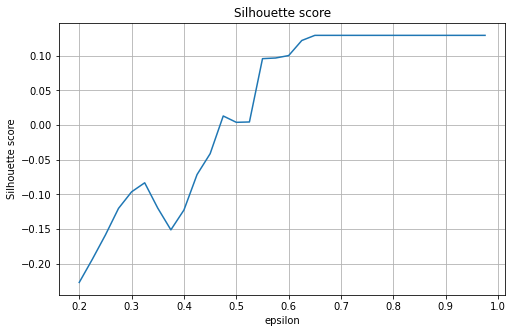

In [40]:
eps_range = np.arange(0.2, 1, 0.025)
plot_dbscan(intents_embeddings, eps_range)

In [41]:
db = DBSCAN(eps=0.5, min_samples=3, metric='cosine').fit(intents_embeddings)
labels = db.labels_
len(np.unique(labels))

6

In [42]:
silhouette_score(intents_embeddings, labels, metric='cosine')

0.0039090114

### HDBSCAN

In [43]:
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=2, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(intents_embeddings)

labels = clusters_hdbscan.labels_
len(np.unique(labels))

212

In [44]:
np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)

376